In [ ]:
!pip install swig
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 34.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import torch
from torch import cuda, device, distributions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import math

import gymnasium as gym
import os, random
from pathlib import Path
from collections import deque

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

In [3]:
env_id = "MountainCar-v0"
env = gym.make(env_id)#,render_mode="human")

s_size = env.observation_space.shape[0]
a_size = env.action_space.n

print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  2
Sample observation [-0.6105495   0.06882202]


In [4]:
device = device("cuda:0" if cuda.is_available() else "cpu")

In [5]:
def calc_disc_return(r_t , gamma = 0.998):

    G_t = deque(maxlen = len(r_t))
    G_t.append(r_t[-1])

    for i in reversed(r_t[:-1]):
        disc = i + (gamma*G_t[0])
        G_t.appendleft(disc)

    return G_t

class PolGrad(nn.Module):
    def __init__(self, s_size, a_size, h_size):

        super(PolGrad, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, state):

        state = torch.Tensor(state).to(device)
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        return x

class Agent():

    def __init__(self, num_states, num_actions, hidden_lyr, learning_rate=0.001, gamma = 0.99 ):

        self.model = PolGrad(num_states, num_actions, hidden_lyr).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.gamma = gamma

    def act(self,obs):

        probs = F.softmax(self.model.forward(obs), dim =0)
        action_probs = distributions.Categorical(probs)
        action = action_probs.sample()
        log_probs = action_probs.log_prob(action)
        return action.item(),log_probs

    def train(self, rewards, log_probs):

        G_t = calc_disc_return(rewards, self.gamma)
        #mean = np.mean(G_t)
        #std = np.std(G_t) if np.std(G_t) > 0 else 1
        #G_t = (G_t - mean) / std

        loss = 0
        for g, logprob in zip(G_t, log_probs):
            loss += -g * logprob
        loss = loss / len(G_t)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss

In [6]:
hdn_lyr = 64
gamma = 0.999
episodes = 60000

my_agent = Agent(s_size, a_size, hdn_lyr)

In [7]:
epi_loss = []
epi_rewards = []
epi_win = []

for epi in range(episodes):

    s = env.reset()[0]
    term , trunc = False, False
    rewards, log_probs = [], []
    win = 0

    while not any([term, trunc]):

        a , log_p = my_agent.act(s)
        log_probs.append(log_p)
        s, r, term ,trunc, _  = env.step(a)

        if s[0]>=0.5:
          r = 100
          win = 1
          term = True
        else:
          r = 100*s[1]*s[1]
        rewards.append(r)

    epi_win.append(win)
    loss = my_agent.train(rewards, log_probs)

    epi_loss.append(loss.item())
    epi_rewards.append(sum(rewards))

    if epi%10 == 0:
        print(f'Episode:{epi} Loss:{loss.item():0.3f} Reward:{sum(rewards):0.3f} Win Rate:{np.array(epi_win[-100:]).mean():0.3f}')

    if epi%100 == 0:
        clear_output()

    if np.array(epi_win[-100:]).mean()>0.95:
      break



Episode:12810 Loss:21.249 Reward:108.874 Win Rate:0.920
Episode:12820 Loss:11.513 Reward:117.639 Win Rate:0.920
Episode:12830 Loss:1.223 Reward:6.221 Win Rate:0.900
Episode:12840 Loss:14.523 Reward:105.252 Win Rate:0.900
Episode:12850 Loss:13.731 Reward:115.794 Win Rate:0.920
Episode:12860 Loss:16.704 Reward:109.717 Win Rate:0.940
Episode:12870 Loss:18.760 Reward:113.336 Win Rate:0.940
Episode:12880 Loss:13.254 Reward:113.015 Win Rate:0.950


In [8]:
eval_env = gym.make(env_id,render_mode="human")

for epi in range(10):

    s = eval_env.reset()[0]
    term = False
    trunc = False
    win = 0
    n=0
    while not any([term, trunc]):

        a , log_p = my_agent.act(s)
        s, r, term ,trunc , _  = eval_env.step(a)
        #s = np.copy(s_)
        env.render()
        n+=1
    if s[0]>=0.5:
        win = 1
    print(f'End of Trial Episode {epi} result {win}')
eval_env.close()

C:\Users\arind\anaconda3\envs\torch\lib\site-packages\gymnasium\envs\classic_control\mountain_car.py:173: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("MountainCar-v0", render_mode="rgb_array")
  gym.logger.warn(


End of Trial Episode 0 result 1
End of Trial Episode 1 result 1
End of Trial Episode 2 result 1
End of Trial Episode 3 result 1
End of Trial Episode 4 result 1
End of Trial Episode 5 result 1
End of Trial Episode 6 result 0
End of Trial Episode 7 result 1
End of Trial Episode 8 result 1
End of Trial Episode 9 result 1


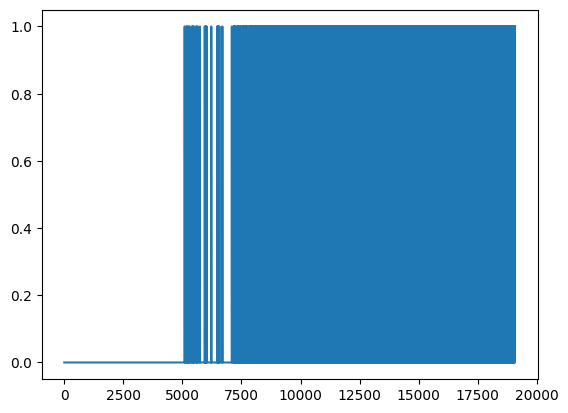

In [17]:
import matplotlib.pyplot as plt
import numpy as np

ypoints = np.array([3, 8, 1, 10])

plt.plot(epi_win, linestyle = 'solid')
plt.show()

In [18]:
log_probs

[tensor(-0.4920, device='cuda:0', grad_fn=<SqueezeBackward1>),
 tensor(-0.4158, device='cuda:0', grad_fn=<SqueezeBackward1>),
 tensor(-1.2272, device='cuda:0', grad_fn=<SqueezeBackward1>),
 tensor(-1.1903, device='cuda:0', grad_fn=<SqueezeBackward1>),
 tensor(-0.3843, device='cuda:0', grad_fn=<SqueezeBackward1>),
 tensor(-0.3273, device='cuda:0', grad_fn=<SqueezeBackward1>),
 tensor(-0.2798, device='cuda:0', grad_fn=<SqueezeBackward1>),
 tensor(-0.2406, device='cuda:0', grad_fn=<SqueezeBackward1>),
 tensor(-0.2086, device='cuda:0', grad_fn=<SqueezeBackward1>),
 tensor(-0.1825, device='cuda:0', grad_fn=<SqueezeBackward1>),
 tensor(-0.1616, device='cuda:0', grad_fn=<SqueezeBackward1>),
 tensor(-0.1449, device='cuda:0', grad_fn=<SqueezeBackward1>),
 tensor(-0.1317, device='cuda:0', grad_fn=<SqueezeBackward1>),
 tensor(-0.1216, device='cuda:0', grad_fn=<SqueezeBackward1>),
 tensor(-0.1141, device='cuda:0', grad_fn=<SqueezeBackward1>),
 tensor(-0.1088, device='cuda:0', grad_fn=<SqueezeBackw